# Road Follower - Train Model

In this notebook we will train a neural network to take an input image, and output a set of x, y values corresponding to a target.

We will be using PyTorch deep learning framework to train ResNet18 neural network architecture model for road follower application.

In [1]:
import torch
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.datasets as datasets
import torchvision.models as models
import torchvision.transforms as transforms
import glob
import os
import numpy as np
from ignite.handlers import ModelCheckpoint
import matplotlib.pyplot as plt
from PIL import Image
import PIL
import time
import pprint
from ignite.engine import Events, create_supervised_trainer, create_supervised_evaluator, Engine
from ignite.metrics import Accuracy, Loss, RunningAverage, Precision, Recall, MetricsLambda
from ignite.contrib.handlers import ProgressBar

### Download and extract data

Before you start, you should upload the ``road_following_<Date&Time>.zip`` file that you created in the ``data_collection.ipynb`` notebook on the robot. 

> If you're training on the JetBot you collected data on, you can skip this!

You should then extract this dataset by calling the command below:

In [2]:
def preprocess_image(image_path, image):
    x = float(get_x(os.path.basename(image_path)))
    y = float(get_y(os.path.basename(image_path)))

    color_jitter = transforms.ColorJitter(0.3, 0.3, 0.3, 0.3)
    image = color_jitter(image)
    image = transforms.functional.resize(image, (224, 224))
    image = transforms.functional.to_tensor(image)
    image = image.numpy()[::-1].copy()
    image = torch.from_numpy(image)
    image = transforms.functional.normalize(image, [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

    return image, torch.tensor([x, y]).float()

### Create Dataset Instance

Here we create a custom ``torch.utils.data.Dataset`` implementation, which implements the ``__len__`` and ``__getitem__`` functions.  This class
is responsible for loading images and parsing the x, y values from the image filenames.  Because we implement the ``torch.utils.data.Dataset`` class,
we can use all of the torch data utilities :)

We hard coded some transformations (like color jitter) into our dataset.  We made random horizontal flips optional (in case you want to follow a non-symmetric path, like a road
where we need to 'stay right').  If it doesn't matter whether your robot follows some convention, you could enable flips to augment the dataset.

In [3]:
def get_x(path):
    """Gets the x value from the image filename"""
    return (float(int(path[3:6])) - 50.0) / 50.0

def get_y(path):
    """Gets the y value from the image filename"""
    return (float(int(path[7:10])) - 50.0) / 50.0

image_paths = glob.glob(os.path.join('dataset_xy', '*.jpg'))


augmented_dataset = []
for image_path in image_paths:
    original_image = PIL.Image.open(image_path)
    brightness_enhancer = PIL.ImageEnhance.Brightness(original_image)
    dark_image = brightness_enhancer.enhance(0.4)
    bright_image = brightness_enhancer.enhance(3)
    
    augmented_dataset.append(preprocess_image(image_path, original_image))            
    augmented_dataset.append(preprocess_image(image_path, dark_image))
    augmented_dataset.append(preprocess_image(image_path, bright_image))
    
# additional augmentation filters
#     mode_image = original_image.filter(PIL.ImageFilter.ModeFilter(5))        
#     blurred_image = original_image.filter(PIL.ImageFilter.GaussianBlur(5))   
#     sharp_image = original_image.filter(PIL.ImageFilter.UnsharpMask(7))   
#     enhanced_image = original_image.filter(PIL.ImageFilter.EDGE_ENHANCE_MORE())

In [4]:
len(augmented_dataset)

1686

In [5]:
len(image_paths)

562

### Split dataset into train and test sets
Once we read dataset, we will split data set in train and test sets. In this example we split train and test a 90%-10%. The test set will be used to verify the accuracy of the model we train.

In [6]:
test_percent = 0.4
num_test = int(test_percent * len(augmented_dataset))
train_dataset, test_dataset = torch.utils.data.random_split(augmented_dataset, [len(augmented_dataset) - num_test, num_test])

In [7]:
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=8,
    shuffle=True,
    num_workers=4 # Only one worker to work around windows10 bug!
)

val_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=8,
    shuffle=False,
    num_workers=4 # Only one worker to work around windows10 bug!
)

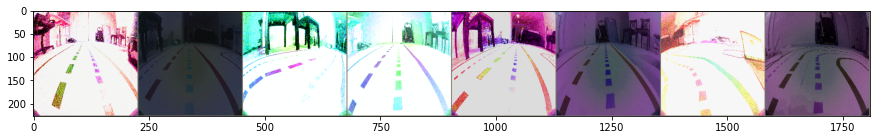

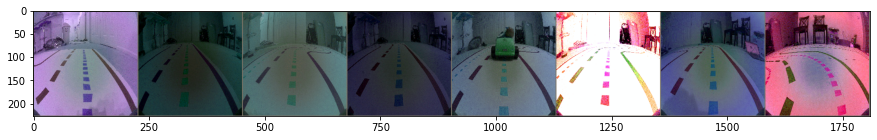

In [8]:
def imshow(inp):
    plt.figure(figsize=(15,15))
    """Custom imshow for the preprocessed dataset"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp[:-1])
    plt.pause(0.001)


# get the first two batches from the training loader
inputs1, lbl1 = next(iter(train_loader))
inputs2, lbl2 = next(iter(train_loader))

# create a grid
out1 = torchvision.utils.make_grid(inputs1)
out2 = torchvision.utils.make_grid(inputs2)

# show the first two batches
imshow(out1)
imshow(out2)

### Create data loaders to load data in batches

We use ``DataLoader`` class to load data in batches, shuffle data and allow using multi-subprocesses. In this example we use batch size of 64. Batch size will be based on memory available with your GPU and it can impact accuracy of the model.

### Define Neural Network Model 

We use ResNet-18 model available on PyTorch TorchVision. 

In a process called transfer learning, we can repurpose a pre-trained model (trained on millions of images) for a new task that has possibly much less data available.


More details on ResNet-18 : https://github.com/pytorch/vision/blob/master/torchvision/models/resnet.py

More Details on Transfer Learning: https://www.youtube.com/watch?v=yofjFQddwHE 

ResNet model has fully connect (fc) final layer with 512 as ``in_features`` and we will be training for regression thus ``out_features`` as 1

Finally, we transfer our model for execution on the GPU

<span style="font-family: Arial; font-size:1.4em;color:blue;">The restnet model layers</span>

In [9]:
model = models.resnet18(pretrained=True, progress=True)
model.fc = torch.nn.Linear(512, 2)
device = torch.device('cuda')
model = model.to(device)

In [10]:
for idx, m in enumerate(model.modules()):
    print(idx, '->', m)

0 -> ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=Tru

### Train Regression:

We train for 50 epochs and save best model if the loss is reduced. 

Once the model is trained, it will generate ``best_steering_model_xy.pth`` file which you can use for inferencing in the live demo notebook.

If you trained on a different machine other than JetBot, you'll need to upload this to the JetBot to the ``road_following`` example folder.

In [11]:
NUM_EPOCHS= 50


optimizer = optim.Adam(model.parameters(), lr=0.0001)
criterion = torch.nn.MSELoss().to(device)


def process_function(engine, batch):
    model.train()
    optimizer.zero_grad()
    x, y =batch
    x = x.to(device)
    y = y.to(device)
    y_pred = model(x)
    loss = criterion(y_pred, y)
    loss.backward()
    optimizer.step()
    return loss.item()


def eval_function(engine, batch):
    model.eval()
    x, y = batch
    x = x.to(device)
    y = y.to(device)
    y_pred = model(x)
    return y_pred, y


def thresholded_output_transform(output):
    y_pred, y = output
    y_pred_tag = torch.round(torch.sigmoid(y_pred))
    y_pred = torch.round(y_pred)
    y_tag = torch.round(torch.sigmoid(y))
    y = torch.round(y_pred)
    return  y_pred_tag, y_tag


trainer = Engine(process_function)
train_evaluator = Engine(eval_function)
validation_evaluator = Engine(eval_function)


RunningAverage(output_transform=lambda x: x).attach(trainer, 'loss')


acc = Accuracy(output_transform=thresholded_output_transform)
loss = Loss(criterion)
precision = Precision(average=False, output_transform=thresholded_output_transform)
recall = Recall(average=False, output_transform=thresholded_output_transform)
f1 = precision * recall * 2 / (precision + recall + 1e-20)
f1 = MetricsLambda(lambda t: torch.mean(t).item(), f1)

acc.attach(train_evaluator, 'accuracy')
loss.attach(train_evaluator, 'ce')
precision.attach(train_evaluator, 'precision')
recall.attach(train_evaluator, 'recall')
f1.attach(train_evaluator, 'f1')


acc = Accuracy(output_transform=thresholded_output_transform)
loss = Loss(criterion)
precision = Precision(average=False, output_transform=thresholded_output_transform)
recall = Recall(average=False, output_transform=thresholded_output_transform)
f1 = precision * recall * 2 / (precision + recall + 1e-20)
f1 = MetricsLambda(lambda t: torch.mean(t).item(), f1)

acc.attach(validation_evaluator, 'accuracy')
loss.attach(validation_evaluator, 'ce')
precision.attach(validation_evaluator, 'precision')
recall.attach(validation_evaluator, 'recall')
f1.attach(validation_evaluator, 'f1')



pbar = ProgressBar(persist=True, bar_format="")
pbar.attach(trainer, ['loss'])



training_history = {'accuracy':[],'loss':[], 'f1':[]}
validation_history = {'accuracy':[],'loss':[],'f1':[]}


@trainer.on(Events.EPOCH_COMPLETED)
def log_training_results(engine):
    train_evaluator.run(train_loader)
    metrics = train_evaluator.state.metrics
    training_history['accuracy'].append(metrics["accuracy"])
    training_history['loss'].append(metrics["ce"])
    training_history['f1'].append(metrics["f1"])
    pbar.log_message(
        "Training Results - Epoch: {} \nMetrics\n{}\n"
        .format(engine.state.epoch, pprint.pformat(metrics)))
    

@trainer.on(Events.EPOCH_COMPLETED)
def log_validation_results(engine):
    validation_evaluator.run(val_loader)
    metrics = validation_evaluator.state.metrics
    validation_history['accuracy'].append(metrics["accuracy"])
    validation_history['loss'].append(metrics["ce"])
    validation_history['f1'].append(metrics["f1"])
    pbar.log_message(
        "Validation Results - Epoch: {} \nMetrics\n{}\n"
        .format(engine.state.epoch, pprint.pformat(metrics)))
    pbar.n = pbar.last_print_n = 0



def score_function(engine):
    score = engine.state.metrics['f1']
    return score

checkpointer = ModelCheckpoint('checkpoint', 
                               'best_model_18_pretrained',
                               n_saved=2,
                               create_dir=True,
                               require_empty=False,
                               save_as_state_dict=True)

best_model_save = ModelCheckpoint('best_model_18_pretrained',
                                  'best_model_18_pretrained',
                                  n_saved=1,
                                  create_dir=True,
                                  save_as_state_dict=True,
                                  require_empty=True,
                                  score_function=score_function)


trainer.add_event_handler(Events.EPOCH_COMPLETED, checkpointer, {'steering': model})
validation_evaluator.add_event_handler(Events.EPOCH_COMPLETED, best_model_save, {'steering': model})

since = time.time()

trainer.run(train_loader, max_epochs=NUM_EPOCHS)

time_elapsed = time.time() - since
print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))


Training Results - Epoch: 1 
Metrics
{'accuracy': 0.8068181818181818,
 'ce': 0.0527031347818172,
 'f1': 0.8521739130434782,
 'precision': 0.8429319371727748,
 'recall': 0.8616207951070336}

Validation Results - Epoch: 1 
Metrics
{'accuracy': 0.8323442136498517,
 'ce': 0.03506141202386126,
 'f1': 0.8748615725359912,
 'precision': 0.8605664488017429,
 'recall': 0.8896396396396397}




Training Results - Epoch: 2 
Metrics
{'accuracy': 0.7223320158102767,
 'ce': 0.0313317351661652,
 'f1': 0.8183581124757595,
 'precision': 0.7088465845464725,
 'recall': 0.9678899082568807}

Validation Results - Epoch: 2 
Metrics
{'accuracy': 0.7403560830860534,
 'ce': 0.030648000914194465,
 'f1': 0.8330152671755725,
 'precision': 0.722682119205298,
 'recall': 0.9831081081081081}




Training Results - Epoch: 3 
Metrics
{'accuracy': 0.8458498023715415,
 'ce': 0.005836420904167674,
 'f1': 0.8904494382022473,
 'precision': 0.8233766233766234,
 'recall': 0.9694189602446484}

Validation Results - Epoch: 3 
Metrics
{'accuracy': 0.8694362017804155,
 'ce': 0.006413996495473688,
 'f1': 0.9079497907949792,
 'precision': 0.84765625,
 'recall': 0.9774774774774775}




Training Results - Epoch: 4 
Metrics
{'accuracy': 0.799901185770751,
 'ce': 0.0045503530570346375,
 'f1': 0.8640483383685801,
 'precision': 0.770197486535009,
 'recall': 0.9839449541284404}

Validation Results - Epoch: 4 
Metrics
{'accuracy': 0.8086053412462908,
 'ce': 0.005985315619672176,
 'f1': 0.8721506442021804,
 'precision': 0.7787610619469026,
 'recall': 0.990990990990991}




Training Results - Epoch: 5 
Metrics
{'accuracy': 0.9471343873517787,
 'ce': 0.006198216174460447,
 'f1': 0.9582520483808038,
 'precision': 0.9784860557768924,
 'recall': 0.9388379204892966}

Validation Results - Epoch: 5 
Metrics
{'accuracy': 0.9376854599406528,
 'ce': 0.00724418077186767,
 'f1': 0.951388888888889,
 'precision': 0.9785714285714285,
 'recall': 0.9256756756756757}




Training Results - Epoch: 6 
Metrics
{'accuracy': 0.9431818181818182,
 'ce': 0.0029814624477899356,
 'f1': 0.955270322831583,
 'precision': 0.9722882026920031,
 'recall': 0.9388379204892966}

Validation Results - Epoch: 6 
Metrics
{'accuracy': 0.9428783382789317,
 'ce': 0.004207911704617168,
 'f1': 0.9559244419004007,
 'precision': 0.9720605355064028,
 'recall': 0.9403153153153153}




Training Results - Epoch: 7 
Metrics
{'accuracy': 0.8908102766798419,
 'ce': 0.0016990415084731615,
 'f1': 0.9213243147027411,
 'precision': 0.8620919387075283,
 'recall': 0.9892966360856269}

Validation Results - Epoch: 7 
Metrics
{'accuracy': 0.8961424332344213,
 'ce': 0.0028057432469555375,
 'f1': 0.9262381454162277,
 'precision': 0.8702970297029703,
 'recall': 0.9898648648648649}




Training Results - Epoch: 8 
Metrics
{'accuracy': 0.9229249011857708,
 'ce': 0.0011828243219396725,
 'f1': 0.9429824561403509,
 'precision': 0.9033613445378151,
 'recall': 0.9862385321100917}

Validation Results - Epoch: 8 
Metrics
{'accuracy': 0.93026706231454,
 'ce': 0.0023447869252966225,
 'f1': 0.949134199134199,
 'precision': 0.9135416666666667,
 'recall': 0.9876126126126126}




Training Results - Epoch: 9 
Metrics
{'accuracy': 0.9397233201581028,
 'ce': 0.0009665096417003175,
 'f1': 0.9548148148148149,
 'precision': 0.9260057471264368,
 'recall': 0.985474006116208}

Validation Results - Epoch: 9 
Metrics
{'accuracy': 0.9451038575667656,
 'ce': 0.002121597358843627,
 'f1': 0.9596069868995634,
 'precision': 0.9311440677966102,
 'recall': 0.9898648648648649}




Training Results - Epoch: 10 
Metrics
{'accuracy': 0.9728260869565217,
 'ce': 0.0019596681733185005,
 'f1': 0.978772674642995,
 'precision': 0.9883086515978177,
 'recall': 0.9694189602446484}

Validation Results - Epoch: 10 
Metrics
{'accuracy': 0.9688427299703264,
 'ce': 0.002854649530231776,
 'f1': 0.9761092150170648,
 'precision': 0.9862068965517241,
 'recall': 0.9662162162162162}




Training Results - Epoch: 11 
Metrics
{'accuracy': 0.9575098814229249,
 'ce': 0.003480377586801415,
 'f1': 0.9660615627466456,
 'precision': 0.99836867862969,
 'recall': 0.9357798165137615}

Validation Results - Epoch: 11 
Metrics
{'accuracy': 0.9562314540059347,
 'ce': 0.004507086847740217,
 'f1': 0.9656777196044212,
 'precision': 0.9987966305655837,
 'recall': 0.9346846846846847}




Training Results - Epoch: 12 
Metrics
{'accuracy': 0.9189723320158103,
 'ce': 0.001155272145293609,
 'f1': 0.9405366207396665,
 'precision': 0.8944827586206896,
 'recall': 0.9915902140672783}

Validation Results - Epoch: 12 
Metrics
{'accuracy': 0.9235905044510386,
 'ce': 0.0020702522629229437,
 'f1': 0.9446534121440086,
 'precision': 0.9033915724563206,
 'recall': 0.9898648648648649}




Training Results - Epoch: 13 
Metrics
{'accuracy': 0.9683794466403162,
 'ce': 0.001105975476438695,
 'f1': 0.9757023538344722,
 'precision': 0.969079939668175,
 'recall': 0.9824159021406728}

Validation Results - Epoch: 13 
Metrics
{'accuracy': 0.9547477744807121,
 'ce': 0.0019270541515679428,
 'f1': 0.9661299278178789,
 'precision': 0.9529025191675794,
 'recall': 0.9797297297297297}




Training Results - Epoch: 14 
Metrics
{'accuracy': 0.8379446640316206,
 'ce': 0.0008844858851732885,
 'f1': 0.888359428182437,
 'precision': 0.8006134969325154,
 'recall': 0.9977064220183486}

Validation Results - Epoch: 14 
Metrics
{'accuracy': 0.8508902077151336,
 'ce': 0.001853581825468153,
 'f1': 0.8981246832235176,
 'precision': 0.8165898617511521,
 'recall': 0.9977477477477478}




Training Results - Epoch: 15 
Metrics
{'accuracy': 0.9491106719367589,
 'ce': 0.0006847044357775965,
 'f1': 0.9614953271028037,
 'precision': 0.9407461594732992,
 'recall': 0.9831804281345565}

Validation Results - Epoch: 15 
Metrics
{'accuracy': 0.9614243323442137,
 'ce': 0.001567806338667538,
 'f1': 0.9712070874861573,
 'precision': 0.9553376906318083,
 'recall': 0.9876126126126126}




Training Results - Epoch: 16 
Metrics
{'accuracy': 0.9362648221343873,
 'ce': 0.0008329787063127081,
 'f1': 0.9524511610762993,
 'precision': 0.9195729537366548,
 'recall': 0.9877675840978594}

Validation Results - Epoch: 16 
Metrics
{'accuracy': 0.9258160237388724,
 'ce': 0.0015796708783897564,
 'f1': 0.9461206896551724,
 'precision': 0.9070247933884298,
 'recall': 0.9887387387387387}




Training Results - Epoch: 17 
Metrics
{'accuracy': 0.9461462450592886,
 'ce': 0.0015990942143264554,
 'f1': 0.9596445760829322,
 'precision': 0.9303661162957645,
 'recall': 0.9908256880733946}

Validation Results - Epoch: 17 
Metrics
{'accuracy': 0.9532640949554896,
 'ce': 0.0023402257287703475,
 'f1': 0.9655172413793104,
 'precision': 0.939297124600639,
 'recall': 0.9932432432432432}




Training Results - Epoch: 18 
Metrics
{'accuracy': 0.9224308300395256,
 'ce': 0.0005389047919343715,
 'f1': 0.9430540442509975,
 'precision': 0.8971704623878537,
 'recall': 0.9938837920489296}

Validation Results - Epoch: 18 
Metrics
{'accuracy': 0.93026706231454,
 'ce': 0.0012826549095856109,
 'f1': 0.9496248660235799,
 'precision': 0.9059304703476483,
 'recall': 0.9977477477477478}




Training Results - Epoch: 19 
Metrics
{'accuracy': 0.9565217391304348,
 'ce': 0.0006726396588973054,
 'f1': 0.9667924528301887,
 'precision': 0.9545454545454546,
 'recall': 0.9793577981651376}

Validation Results - Epoch: 19 
Metrics
{'accuracy': 0.962166172106825,
 'ce': 0.001271476771527741,
 'f1': 0.971776425013835,
 'precision': 0.955386289445049,
 'recall': 0.9887387387387387}




Training Results - Epoch: 20 
Metrics
{'accuracy': 0.8942687747035574,
 'ce': 0.0006296235607640648,
 'f1': 0.9243281471004244,
 'precision': 0.8598684210526316,
 'recall': 0.9992354740061162}

Validation Results - Epoch: 20 
Metrics
{'accuracy': 0.9117210682492581,
 'ce': 0.0012891268509976257,
 'f1': 0.9370703331570598,
 'precision': 0.8833499501495513,
 'recall': 0.9977477477477478}




Training Results - Epoch: 21 
Metrics
{'accuracy': 0.8759881422924901,
 'ce': 0.0009019349203831534,
 'f1': 0.9120224325271644,
 'precision': 0.8420711974110032,
 'recall': 0.9946483180428135}

Validation Results - Epoch: 21 
Metrics
{'accuracy': 0.8939169139465876,
 'ce': 0.0016695982258413153,
 'f1': 0.9254820218863992,
 'precision': 0.8612997090203686,
 'recall': 1.0}




Training Results - Epoch: 22 
Metrics
{'accuracy': 0.9654150197628458,
 'ce': 0.0006462232716585852,
 'f1': 0.9735049205147615,
 'precision': 0.9640179910044977,
 'recall': 0.9831804281345565}

Validation Results - Epoch: 22 
Metrics
{'accuracy': 0.9747774480712166,
 'ce': 0.0012818138026673821,
 'f1': 0.9808558558558559,
 'precision': 0.9808558558558559,
 'recall': 0.9808558558558559}




Training Results - Epoch: 23 
Metrics
{'accuracy': 0.95899209486166,
 'ce': 0.0009896190571985226,
 'f1': 0.9688555347091932,
 'precision': 0.9513633014001474,
 'recall': 0.9870030581039755}

Validation Results - Epoch: 23 
Metrics
{'accuracy': 0.9673590504451038,
 'ce': 0.0015254976277623757,
 'f1': 0.9755011135857461,
 'precision': 0.9647577092511013,
 'recall': 0.9864864864864865}




Training Results - Epoch: 24 
Metrics
{'accuracy': 0.9812252964426877,
 'ce': 0.0007254802304404703,
 'f1': 0.9853846153846154,
 'precision': 0.9914860681114551,
 'recall': 0.9793577981651376}

Validation Results - Epoch: 24 
Metrics
{'accuracy': 0.9755192878338279,
 'ce': 0.0013500077230924911,
 'f1': 0.9813453928773317,
 'precision': 0.985244040862656,
 'recall': 0.9774774774774775}




Training Results - Epoch: 25 
Metrics
{'accuracy': 0.8651185770750988,
 'ce': 0.0006556458352041603,
 'f1': 0.9055036344755971,
 'precision': 0.8273244781783681,
 'recall': 1.0}

Validation Results - Epoch: 25 
Metrics
{'accuracy': 0.8954005934718101,
 'ce': 0.0012991430475556179,
 'f1': 0.9263707571801567,
 'precision': 0.8636806231742941,
 'recall': 0.9988738738738738}




Training Results - Epoch: 26 
Metrics
{'accuracy': 0.8829051383399209,
 'ce': 0.0010625941397276204,
 'f1': 0.9168712732374606,
 'precision': 0.847051198963059,
 'recall': 0.9992354740061162}

Validation Results - Epoch: 26 
Metrics
{'accuracy': 0.9094955489614244,
 'ce': 0.0016208193492896037,
 'f1': 0.9356540084388185,
 'precision': 0.8799603174603174,
 'recall': 0.9988738738738738}




Training Results - Epoch: 27 
Metrics
{'accuracy': 0.9120553359683794,
 'ce': 0.0003832736568619302,
 'f1': 0.9362464183381088,
 'precision': 0.8807277628032345,
 'recall': 0.9992354740061162}

Validation Results - Epoch: 27 
Metrics
{'accuracy': 0.9391691394658753,
 'ce': 0.001101909304633239,
 'f1': 0.9556756756756757,
 'precision': 0.918918918918919,
 'recall': 0.9954954954954955}




Training Results - Epoch: 28 
Metrics
{'accuracy': 0.9051383399209486,
 'ce': 0.00029852889430352116,
 'f1': 0.9314775160599572,
 'precision': 0.8734939759036144,
 'recall': 0.9977064220183486}

Validation Results - Epoch: 28 
Metrics
{'accuracy': 0.9198813056379822,
 'ce': 0.0009010903470256872,
 'f1': 0.9424307036247336,
 'precision': 0.8947368421052632,
 'recall': 0.9954954954954955}




Training Results - Epoch: 29 
Metrics
{'accuracy': 0.9792490118577075,
 'ce': 0.0010294367390382931,
 'f1': 0.9836956521739131,
 'precision': 0.999211356466877,
 'recall': 0.9686544342507645}

Validation Results - Epoch: 29 
Metrics
{'accuracy': 0.9799703264094956,
 'ce': 0.0015755709535677197,
 'f1': 0.9845978322875071,
 'precision': 0.9976878612716763,
 'recall': 0.9718468468468469}




Training Results - Epoch: 30 
Metrics
{'accuracy': 0.9782608695652174,
 'ce': 0.0004477113297944447,
 'f1': 0.9832444782939833,
 'precision': 0.9795144157814871,
 'recall': 0.9870030581039755}

Validation Results - Epoch: 30 
Metrics
{'accuracy': 0.973293768545994,
 'ce': 0.0009502584696920085,
 'f1': 0.9798432250839866,
 'precision': 0.9743875278396437,
 'recall': 0.9853603603603603}




Training Results - Epoch: 31 
Metrics
{'accuracy': 0.983201581027668,
 'ce': 0.0006953694580652909,
 'f1': 0.9868319132455462,
 'precision': 1.0,
 'recall': 0.9740061162079511}

Validation Results - Epoch: 31 
Metrics
{'accuracy': 0.9792284866468842,
 'ce': 0.001118047038011684,
 'f1': 0.9840182648401826,
 'precision': 0.9976851851851852,
 'recall': 0.9707207207207207}




Training Results - Epoch: 32 
Metrics
{'accuracy': 0.9713438735177866,
 'ce': 0.0005862738439268451,
 'f1': 0.9779969650986342,
 'precision': 0.9706325301204819,
 'recall': 0.985474006116208}

Validation Results - Epoch: 32 
Metrics
{'accuracy': 0.9762611275964391,
 'ce': 0.0011236592664352952,
 'f1': 0.9820426487093153,
 'precision': 0.9787472035794184,
 'recall': 0.9853603603603603}




Training Results - Epoch: 33 
Metrics
{'accuracy': 0.9407114624505929,
 'ce': 0.00034797642772383216,
 'f1': 0.956043956043956,
 'precision': 0.9177215189873418,
 'recall': 0.9977064220183486}

Validation Results - Epoch: 33 
Metrics
{'accuracy': 0.9451038575667656,
 'ce': 0.0008588291625892992,
 'f1': 0.9599133261105092,
 'precision': 0.9248434237995825,
 'recall': 0.9977477477477478}




Training Results - Epoch: 34 
Metrics
{'accuracy': 0.9446640316205533,
 'ce': 0.00033411451735259533,
 'f1': 0.958914159941306,
 'precision': 0.9217207334273625,
 'recall': 0.9992354740061162}

Validation Results - Epoch: 34 
Metrics
{'accuracy': 0.9525222551928784,
 'ce': 0.0008692190998291889,
 'f1': 0.9651795429815015,
 'precision': 0.9336842105263158,
 'recall': 0.9988738738738738}




Training Results - Epoch: 35 
Metrics
{'accuracy': 0.9678853754940712,
 'ce': 0.0004325190586292851,
 'f1': 0.975517890772128,
 'precision': 0.961395694135115,
 'recall': 0.9900611620795107}

Validation Results - Epoch: 35 
Metrics
{'accuracy': 0.9703264094955489,
 'ce': 0.0008873571298024355,
 'f1': 0.9779005524861878,
 'precision': 0.9598698481561823,
 'recall': 0.9966216216216216}




Training Results - Epoch: 36 
Metrics
{'accuracy': 0.9575098814229249,
 'ce': 0.0022012191206187363,
 'f1': 0.9660079051383399,
 'precision': 1.0,
 'recall': 0.9342507645259939}

Validation Results - Epoch: 36 
Metrics
{'accuracy': 0.9510385756676558,
 'ce': 0.002677370684956496,
 'f1': 0.9614035087719298,
 'precision': 1.0,
 'recall': 0.9256756756756757}




Training Results - Epoch: 37 
Metrics
{'accuracy': 0.9629446640316206,
 'ce': 0.0003500254033317443,
 'f1': 0.971708789136175,
 'precision': 0.9590469099032017,
 'recall': 0.9847094801223242}

Validation Results - Epoch: 37 
Metrics
{'accuracy': 0.9703264094955489,
 'ce': 0.0008698421166325402,
 'f1': 0.977728285077951,
 'precision': 0.9669603524229075,
 'recall': 0.9887387387387387}




Training Results - Epoch: 38 
Metrics
{'accuracy': 0.9772727272727273,
 'ce': 0.0005568677345299983,
 'f1': 0.9824024483550116,
 'precision': 0.9831546707503829,
 'recall': 0.981651376146789}

Validation Results - Epoch: 38 
Metrics
{'accuracy': 0.9814540059347181,
 'ce': 0.0010181480575800605,
 'f1': 0.9858677218767664,
 'precision': 0.9897843359818388,
 'recall': 0.9819819819819819}




Training Results - Epoch: 39 
Metrics
{'accuracy': 0.9891304347826086,
 'ce': 0.0005482332532481831,
 'f1': 0.9915449654112222,
 'precision': 0.9969088098918083,
 'recall': 0.9862385321100917}

Validation Results - Epoch: 39 
Metrics
{'accuracy': 0.9866468842729971,
 'ce': 0.0009084570643738,
 'f1': 0.9898074745186863,
 'precision': 0.9954441913439636,
 'recall': 0.9842342342342343}




Training Results - Epoch: 40 
Metrics
{'accuracy': 0.9920948616600791,
 'ce': 0.0013898661159523745,
 'f1': 0.9938508839354343,
 'precision': 0.999227202472952,
 'recall': 0.9885321100917431}

Validation Results - Epoch: 40 
Metrics
{'accuracy': 0.9873887240356083,
 'ce': 0.0017799997487373495,
 'f1': 0.9903900508762012,
 'precision': 0.9943246311010215,
 'recall': 0.9864864864864865}




Training Results - Epoch: 41 
Metrics
{'accuracy': 0.9782608695652174,
 'ce': 0.001067189402646374,
 'f1': 0.9828926905132193,
 'precision': 1.0,
 'recall': 0.9663608562691132}

Validation Results - Epoch: 41 
Metrics
{'accuracy': 0.978486646884273,
 'ce': 0.001567891166056299,
 'f1': 0.9834190966266438,
 'precision': 0.9988385598141696,
 'recall': 0.9684684684684685}




Training Results - Epoch: 42 
Metrics
{'accuracy': 0.9733201581027668,
 'ce': 0.000329988182942464,
 'f1': 0.9797449362340584,
 'precision': 0.9617083946980854,
 'recall': 0.9984709480122325}

Validation Results - Epoch: 42 
Metrics
{'accuracy': 0.9807121661721068,
 'ce': 0.0007228521959723502,
 'f1': 0.9855233853006681,
 'precision': 0.974669603524229,
 'recall': 0.9966216216216216}




Training Results - Epoch: 43 
Metrics
{'accuracy': 0.8631422924901185,
 'ce': 0.0006510853593002107,
 'f1': 0.9039861351819757,
 'precision': 0.8268864933417882,
 'recall': 0.9969418960244648}

Validation Results - Epoch: 43 
Metrics
{'accuracy': 0.8835311572700296,
 'ce': 0.001019340765369553,
 'f1': 0.9186106791083464,
 'precision': 0.851104707012488,
 'recall': 0.9977477477477478}




Training Results - Epoch: 44 
Metrics
{'accuracy': 0.9767786561264822,
 'ce': 0.0007364830518005188,
 'f1': 0.9817049435578046,
 'precision': 1.0,
 'recall': 0.9640672782874617}

Validation Results - Epoch: 44 
Metrics
{'accuracy': 0.9792284866468842,
 'ce': 0.0011129741761101083,
 'f1': 0.9839816933638443,
 'precision': 1.0,
 'recall': 0.9684684684684685}




Training Results - Epoch: 45 
Metrics
{'accuracy': 0.9738142292490118,
 'ce': 0.0008988789850551443,
 'f1': 0.979321108076473,
 'precision': 1.0,
 'recall': 0.959480122324159}

Validation Results - Epoch: 45 
Metrics
{'accuracy': 0.9688427299703264,
 'ce': 0.0012941466629206692,
 'f1': 0.9757785467128028,
 'precision': 1.0,
 'recall': 0.9527027027027027}




Training Results - Epoch: 46 
Metrics
{'accuracy': 0.8344861660079052,
 'ce': 0.0008097587884017248,
 'f1': 0.8863250763488294,
 'precision': 0.7968273337400854,
 'recall': 0.9984709480122325}

Validation Results - Epoch: 46 
Metrics
{'accuracy': 0.849406528189911,
 'ce': 0.0011607234346202246,
 'f1': 0.8974229408792319,
 'precision': 0.8139321723189734,
 'recall': 1.0}




Training Results - Epoch: 47 
Metrics
{'accuracy': 0.8399209486166008,
 'ce': 0.0008758136718681178,
 'f1': 0.889795918367347,
 'precision': 0.8014705882352942,
 'recall': 1.0}

Validation Results - Epoch: 47 
Metrics
{'accuracy': 0.8560830860534124,
 'ce': 0.0013255616345992781,
 'f1': 0.9015228426395939,
 'precision': 0.8207024029574861,
 'recall': 1.0}




Training Results - Epoch: 48 
Metrics
{'accuracy': 0.8473320158102767,
 'ce': 0.0005575492333900552,
 'f1': 0.8943589743589744,
 'precision': 0.8089053803339518,
 'recall': 1.0}

Validation Results - Epoch: 48 
Metrics
{'accuracy': 0.870919881305638,
 'ce': 0.000942604114869416,
 'f1': 0.9107692307692308,
 'precision': 0.8361581920903954,
 'recall': 1.0}




Training Results - Epoch: 49 
Metrics
{'accuracy': 0.8305335968379447,
 'ce': 0.0007398690139826962,
 'f1': 0.88376821416469,
 'precision': 0.7936701156421181,
 'recall': 0.9969418960244648}

Validation Results - Epoch: 49 
Metrics
{'accuracy': 0.8405044510385756,
 'ce': 0.0011013802256675585,
 'f1': 0.8917966784096628,
 'precision': 0.8061874431301183,
 'recall': 0.9977477477477478}




Training Results - Epoch: 50 
Metrics
{'accuracy': 0.8621541501976284,
 'ce': 0.000709849116420042,
 'f1': 0.9036269430051814,
 'precision': 0.8241965973534972,
 'recall': 1.0}

Validation Results - Epoch: 50 
Metrics
{'accuracy': 0.8820474777448071,
 'ce': 0.00111369390623749,
 'f1': 0.917829457364341,
 'precision': 0.8481375358166189,
 'recall': 1.0}

Training complete in 48m 45s


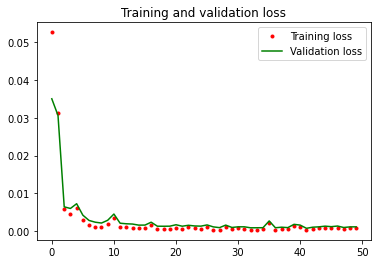

In [12]:
epochs = range(NUM_EPOCHS)

plt.figure()

plt.plot(epochs, training_history['loss'], 'r.', label='Training loss')
plt.plot(epochs, validation_history['loss'], 'g', label='Validation loss')

plt.title('Training and validation loss')
plt.legend()

plt.show()

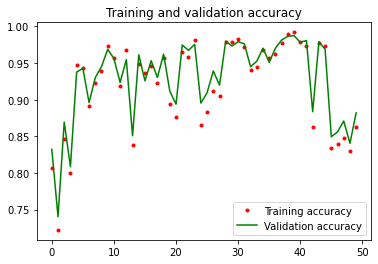

In [13]:
plt.figure()

plt.plot(epochs, training_history['accuracy'], 'r.', label='Training accuracy')
plt.plot(epochs, validation_history['accuracy'], 'g', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.show()

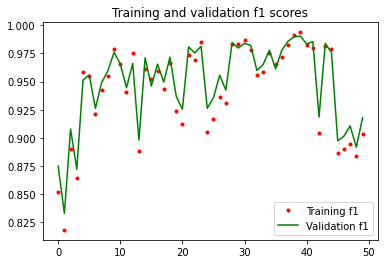

In [14]:
plt.figure()

plt.plot(epochs, training_history['f1'], 'r.', label='Training f1')
plt.plot(epochs, validation_history['f1'], 'g', label='Validation f1')
plt.title('Training and validation f1 scores')
plt.legend()

plt.show()